## Analog discovery using Simba

Modern metabolomics relies on tandem mass spectrometry (MS/MS) to identify the structures of small molecules in complex biological samples. While exact spectral matching against large reference libraries can confidently identify known compounds, discovering analogs, molecules with similar but not identical structures, remains a significant challenge. Analog search is crucial for applications ranging from drug lead optimization to biomarker discovery, where small structural changes can produce different biological effects.

**SIMBA** (Spectral Identification of Molecule Bio-Analogues) is a deep-learning framework designed to bridge this gap. Rather than rely only on heuristic scores like modified cosine, SIMBA’s twin‐transformer architecture learns to predict two chemically interpretable metrics directly from MS/MS spectra:

1. **Substructure Edit Distance (SED):** the minimal number of bond edits (additions/removals) needed to transform one molecule into another via their Maximum Common Substructure (MCS).  
2. **Maximum Common Edge Subgraph (MCES) Distance:** the count of bond differences outside the shared subgraph, offering a complementary view of structural similarity.

This notebook walks you through a typical analog-discovery workflow using SIMBA:

1. **Compute Spectral Embeddings**  
   We begin by computing the MS/MS embeddings generated by SIMBA’s transformer encoders for both query and reference spectra.

2. **Perform Analog Search**  
   We compute pairwise MCES and SED predictions between query spectra (e.g., from the CASMI benchmark) and a reference library ( MassSpecGym) and rank candidates by structural distance.

3. **Evaluate examples**  
   We evaluate some examples of the matches found by SIMBA.

By the end of this notebook, you’ll see how SIMBA’s learned similarity metrics enable more sensitive and interpretable analog retrieval.


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem
from hydra import compose, initialize_config_dir

import simba
from simba.analog_discovery.simba_analog_discovery import AnalogDiscovery
from simba.core.data.ground_truth import GroundTruth
from simba.utils.plotting_mces import Plotting
from simba.core.data.preprocessing_simba import PreprocessingSimba
from simba.core.models.simba_model import Simba
from simba.utils.config_utils import get_config_path

/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining parameters

Define the default configuration variables

In [4]:
# Initialize Hydra config
config_path = get_config_path()
with initialize_config_dir(config_dir=str(config_path), version_base=None):
    cfg = compose(config_name="config")

Location of model saved, reference spectra in mgf file (MASSSPECGYM), an query spectra (CASMI)

In [ ]:
model_location = (
    "/Users/sebas/projects/data/best_model_20250422_only_massspecgym.ckpt"
)
reference_file = "/Users/sebas/projects/data/MassSpecGym.mgf"
casmi_file = (
    "/Users/sebas/projects/data/processed_massformer/casmi2022_spec_df.pkl"
)

## Load spectra

Let's load the reference spectra and query spectra. This code already carries out a preprocessing of the files obtaining only protonized adducts and spectra with at least more than 6 peaks.

In [7]:
all_spectrums_reference = PreprocessingSimba.load_spectra(
    reference_file, cfg, use_gnps_format=False
)

 32%|███▏      | 159139/500000 [01:10<02:30, 2261.27it/s]
2026-01-06 10:48:49 - INFO - 133215 spectra remaining after filtering.


In [8]:
print(
    f"Number of spectra loaded from reference: {len(all_spectrums_reference)}"
)

Number of spectra loaded from reference: 133215


In [9]:
all_spectrums_query = PreprocessingSimba.load_spectra(
    casmi_file, cfg, use_gnps_format=False
)

2026-01-06 10:53:06 - INFO - 158 spectra remaining after filtering.


In [10]:
print(f"Number of spectra loaded from query: {len(all_spectrums_query)}")

Number of spectra loaded from query: 158


##  Let's check some spectra visually

In [11]:
all_spectrums_query[2].params

{'spectrumid': '10 M+H',
 'name': '10 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 10,
 'smiles': 'Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)c3ccccn3)ccc21',
 'ionmode': 'Positive',
 'pepmass': [472.208379934413],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

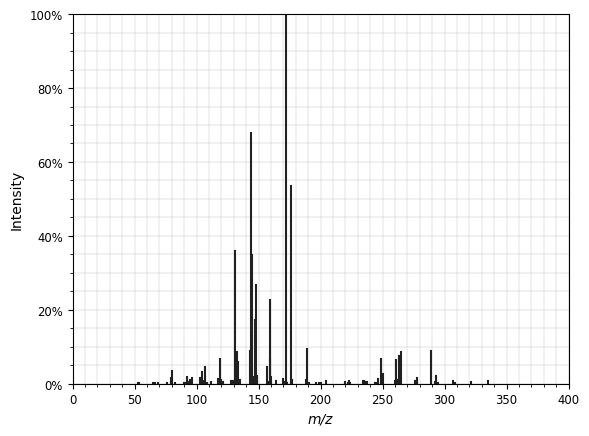

In [17]:
sup.spectrum(all_spectrums_query[2])

## Initialize model

Here we load a simba model based on path specified in 'model_location'. The device to be used is set to 'cpu' unless you have access to a configures GPU. The argument cache_embeddings, allows to reuse embeddings already computed to accelerate future library searchs.

In [13]:
simba_model = Simba(
    model_location, config=cfg, device="cpu", cache_embeddings=True
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of

## Predictions

Based on the simba model created let's predict the substructure edit distance (sim_ed) and MCES distance (sim_mces)

In [14]:
sim_ed, sim_mces = simba_model.predict(
    all_spectrums_query,
    all_spectrums_reference,
)

158it [00:00, 25463.98it/s]
133215it [00:02, 66427.98it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


running
Processing embeddings ...
Predicting DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores



running
Processing embeddings ...
Predicting DataLoader 0: 100%|██████████| 1041/1041 [05:31<00:00,  3.14it/s]


158it [02:09,  1.22it/s]


Elapsed time: 129.38 seconds


In [15]:
sim_mces

array([[31.99556828, 31.61935389, 33.14300478, ..., 28.28802824,
        27.21589923, 26.34391427],
       [13.39839935, 14.84078646, 10.70658684, ..., 23.21400881,
        23.61002922, 21.94936275],
       [19.06650066, 19.78634119, 19.52608824, ..., 23.20398569,
        24.66819406, 23.77721548],
       ...,
       [12.14193344, 13.74959707, 10.67453623, ..., 21.33901596,
        21.99141264, 20.61288238],
       [16.25313759, 15.27415991, 17.05640316, ..., 17.15052366,
        16.48262501, 16.7853117 ],
       [14.55783844, 12.95702457, 14.24301147, ..., 20.98487377,
        21.07420444, 19.27678347]])

The predictions of substructure edit distance are discretized between 0 and 5, being 5 having five or more modifications and 0 having zero modifications. Let's take 10,000 random predictions and check the distribution of the results. Higher substructure edit distances are more common since related molecules are scarse normally.

Text(0, 0.5, 'Frequency')

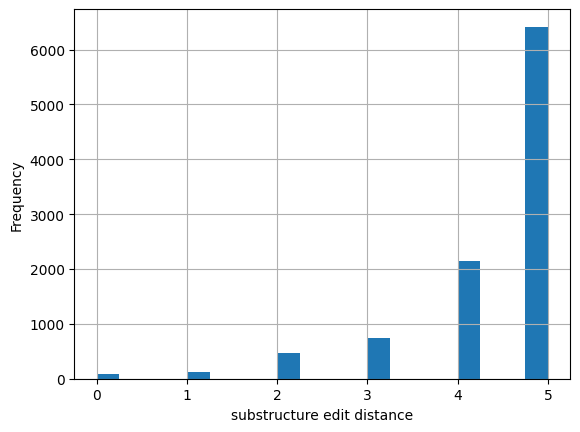

In [16]:
flat = sim_ed.ravel()  # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_ed = flat[idx]
plt.hist(samples_ed, bins=20)
plt.grid()
plt.xlabel("substructure edit distance")
plt.ylabel("Frequency")

The predictions of MCES distance are constrained to 0 to 40 edges. Let's take 10,000 random predictions and check the distribution of the results. Higher MCES distances are more common since related molecules are scarse normally.

Text(0, 0.5, 'Frequency')

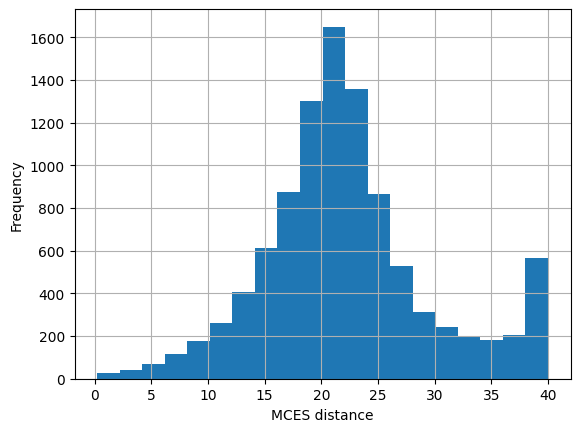

In [17]:
flat = sim_mces.ravel()  # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel("MCES distance")
plt.ylabel("Frequency")

## Reranking

Based on the predictions of MCES and Edit distance we can rerank the results. Lower MCES distance and lower edit distances are higher in the rank. The MCES distance is used as primary metric to rank the predictions given its finer granularity. If 2 predictions have the same MCES distance, the one with the lower substructure edit distance is ranked higher.

In [18]:
ranking = AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

The rank is scaled to 0-1 (normalized to the number of comparisons with the reference library), where 1 means the highest ranking and 0 the lowest ranking.

In [19]:
ranking.shape

(158, 133215)

Text(0, 0.5, 'Frequency')

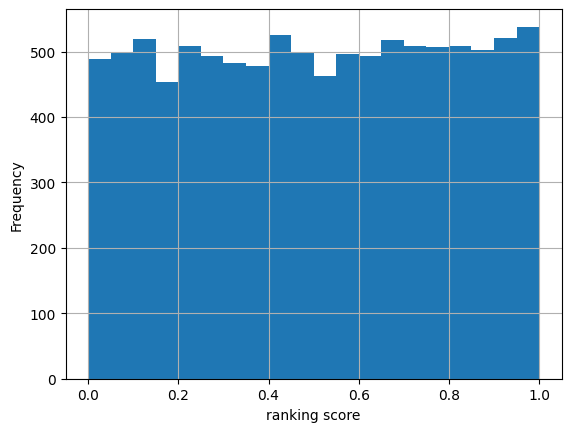

In [20]:
flat = ranking.ravel()  # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel("ranking score")
plt.ylabel("Frequency")

## What is the matched spectra in the reference library for each query spectra?

If we want to find this answer, we have to first select the query spectra we are interested. We can define a variable 'target_index' which indicates the position of the spectrum in the spectra loaded. From there, we can select the 10 highest SIMBA scores and filtering the match with the lowest MCES distance

In [21]:
target_index = 2

In [22]:
spectra_query = all_spectrums_query[target_index]

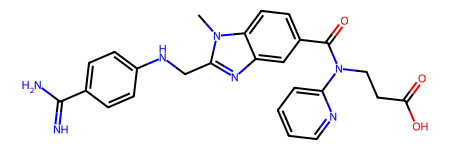

In [23]:
Chem.MolFromSmiles(spectra_query.params["smiles"])

Let's checkwhat are the predictions of the model for this specific query spectra. These are the ranking scores generated for the query spectra selected:

In [24]:
ranking[target_index]

array([0.94007432, 0.92828886, 0.93234996, ..., 0.65009946, 0.44550539,
       0.55891604])

In [25]:
ranking[target_index].shape

(133215,)

Between all the comparisons, we can select the 10 highest scores

In [26]:
best_matches = np.argsort(ranking[target_index])[-10:]

In [27]:
best_matches

array([109568,  95729, 113063,  90086, 101584, 105758, 112947,  92083,
       105759, 101585])

In [28]:
spectra_matches = [all_spectrums_reference[ind] for ind in best_matches]

Let's compute the MCES distances for the matches found and select the best

In [29]:
ground_truth_mces = GroundTruth.compute_mces([spectra_query], spectra_matches)

In [30]:
ground_truth_mces

array([[28. , 20. , 20. , 31.5, 20. ,  2. , 29. , 20. ,  2. , 20. ]])

Let's select the lowest MCES distance

In [31]:
best_match_index = best_matches[np.argmin(ground_truth_mces)]

In [32]:
best_match_index

105758

In [33]:
spectra_match = spectra_matches[np.argmin(ground_truth_mces)]

This is the index in the reference spectra with the best match:

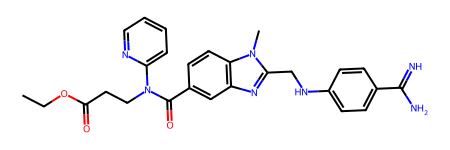

In [34]:
Chem.MolFromSmiles(spectra_match.params["smiles"])

Now take a look at what the model predicts in terms of substructure edit distance and MCES distance for this specfic comparison:

In [35]:
print(
    f"The MCES distance predicted is: {np.round(sim_mces[target_index, best_match_index])}"
)

The MCES distance predicted is: 2.0


In [36]:
print(
    f"The substructure edit distance predicted is: {sim_ed[target_index, best_match_index]}"
)

The substructure edit distance predicted is: 0


## Comparison with ground truth

We can check what is the ground truth edit distance and MCES distance:

In [37]:
ground_truth_mces = GroundTruth.compute_mces([spectra_query], [spectra_match])

In [39]:
print(f"The real MCES distance is: {ground_truth_mces[0,0]}")

The real MCES distance is: 2.0


In [40]:
ground_truth_ed = GroundTruth.compute_edit_distance(
    [spectra_query], [spectra_match]
)

In [41]:
print(f"The real edit distance is: {ground_truth_ed[0,0]}")

The real edit distance is: 1.0


## Comparison predicted vs ground truth

In [42]:
print(
    f"MCES: Ground truth: {ground_truth_mces[0,0]}, predicted {np.round(sim_mces[target_index, best_match_index])}"
)

MCES: Ground truth: 2.0, predicted 2.0


In [43]:
print(
    f"Edit distance: Ground truth: {ground_truth_ed[0,0]}, predicted {np.round(sim_ed[target_index, best_match_index])}"
)

Edit distance: Ground truth: 1.0, predicted 0


## How it looks like the spectra that is found as match?

<Axes: xlabel='m/z', ylabel='Intensity'>

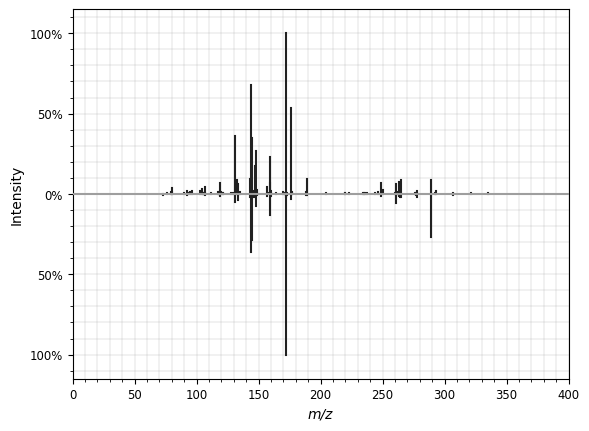

In [44]:
sup.mirror(spectra_query, spectra_match)